Try out different sequence sizes..

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
output_types = (tf.float32,tf.float32)
output_shapes = (tf.TensorShape((None,None)),tf.TensorShape((None,None,1)))

handle = tf.placeholder(tf.string,[])
iterator= tf.data.Iterator.from_string_handle(handle,output_types,output_shapes)
idx,y = iterator.get_next()

In [3]:
NUM_SAMPLES = 2000
SEQ = 30
N = 4.
RESOLUTION = 300
FUNC = lambda : None

tf.set_random_seed(101)
np.random.seed(101)

def function_generator():
    x = np.linspace(0,N*np.pi,RESOLUTION)
    
    y = FUNC(x)
    
    for i in range(NUM_SAMPLES):
        idx = np.random.randint(0,RESOLUTION-SEQ)
        yield (x[idx:idx+SEQ],y[idx:idx+SEQ])
        
def get_dataset(seq:int) -> tf.data.Dataset:
    dataset = tf.data.Dataset.from_generator(function_generator,(tf.float32,tf.float32),(seq,seq))
    dataset = dataset.map(lambda x,y: (x,tf.expand_dims(y,axis=1)))
    dataset = dataset.batch(1)
    return dataset

In [4]:
def f(x):
    return np.sin(x)# + 0.1*x

FUNC = f

train_dataset = get_dataset(SEQ)
train_dataset = train_dataset.repeat(2)
train_iterator = train_dataset.make_one_shot_iterator()

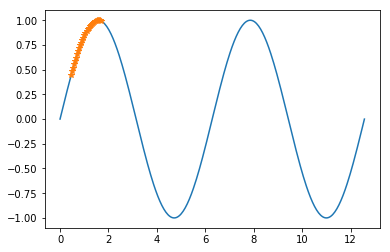

In [5]:
with tf.Session() as sess:
    hdl = sess.run(train_iterator.string_handle())
    x,y_ = sess.run([idx,y],{handle:hdl})
    
    x_full = np.linspace(0,N*np.pi,RESOLUTION)
    plt.plot(x_full,f(x_full))
    plt.plot(x[0],y_[0,:,0],'*')

In [6]:
HIDDEN = 100
cells = [tf.keras.layers.SimpleRNNCell(HIDDEN,activation=tf.nn.relu),]
rnn_layer = tf.keras.layers.RNN(cells,return_sequences=True)

def get_network(X,reuse=tf.AUTO_REUSE):
    with tf.variable_scope("RNN",reuse=reuse):
        H = rnn_layer(X)
    with tf.variable_scope("Out",reuse=reuse):
        outputs = tf.layers.dense(H,1)
        #outputs = tf.layers.dense(H[:,12:],1)
        
    return outputs

In [7]:
target = y[:,1:]
X = y[:,:-1]

# target = y[:,12:]
# X = y[:,:-12]

outputs = get_network(X)
    
loss = tf.reduce_mean(tf.square(outputs-target))
train = tf.train.AdamOptimizer(0.0001).minimize(loss)
saver = tf.train.Saver()

In [8]:
x_in = tf.placeholder(tf.float32,(None,None,1))
outputs_eval = get_network(x_in,reuse=True)

In [9]:
!rm models/RNN4/*

In [4]:
MODEL_SAVE = 'models/RNN4/my_first_model.ckpt'

def train_rnn(iterator:tf.data.Iterator):
    import time
    
    print("SEQ :", SEQ)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        hdl = sess.run(iterator.string_handle())
        
        start = time.time()
        
        try:
            i=0
            tmp = []
            while True:
                l,_ = sess.run([loss,train],{handle:hdl})
                tmp.append(l)
                if i%500 == 0:
                    avg_loss = np.array(tmp).mean()
                    print("Batch: ",i,avg_loss)
                    tmp = []
                i = i+1
                
        except tf.errors.OutOfRangeError:
            avg_loss = np.array(tmp).mean()
            print("Batch: ",i,avg_loss)
            pass
        
        end = time.time()
        elapsed = end-start
        print("Elapsed time : ", elapsed, " s")
        saver.save(sess,MODEL_SAVE)

In [12]:
SEQ = 30
train_rnn(train_iterator)

SEQ : 30
Batch:  0 1.575728
Batch:  500 0.10518527
Batch:  1000 0.013633022
Batch:  1500 0.00872241
Batch:  2000 0.005113487
Batch:  2500 0.003031004
Batch:  3000 0.0017149337
Batch:  3500 0.0008675169
Batch:  4000 0.0004683487
Elapsed time :  17.90988802909851  s


In [5]:
def generate_function(initial_iterator,gen_len=600):
    with tf.Session() as sess:
        saver.restore(sess,MODEL_SAVE)
        hdl_inital = sess.run(initial_iterator.string_handle())

        initial = sess.run(y,{handle:hdl_inital})
        initial = list(initial[0,:,0])

        plt.plot(initial,'*')

        for i in range(gen_len):
            out = sess.run(outputs_eval,{x_in:np.array(initial[-SEQ:]).reshape(1,SEQ,1).astype(np.float)})    

            initial.append(out[0,-1,0])

        plt.plot(initial)

INFO:tensorflow:Restoring parameters from models/RNN4/my_first_model.ckpt


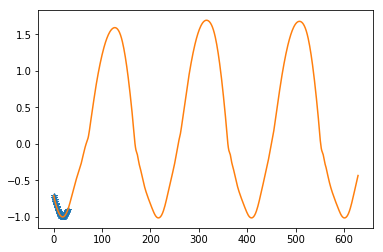

In [14]:
SEQ = 30
initial_dataset = get_dataset(SEQ)
initial_iterator = initial_dataset.make_one_shot_iterator()

generate_function(initial_iterator)

## 2

Increase sequence length

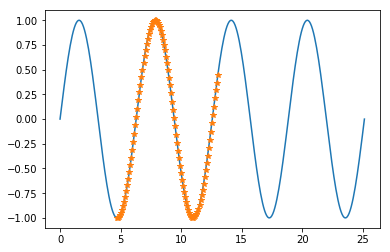

In [16]:
SEQ = 100
N = 8.
RESOLUTION = 300

def f(x):
    return np.sin(x)# + 0.1*x

FUNC = f

train_dataset_1 = get_dataset(SEQ)
train_dataset_1 = train_dataset_1.repeat(2)
train_iterator_1 = train_dataset_1.make_one_shot_iterator()

with tf.Session() as sess:
    hdl = sess.run(train_iterator_1.string_handle())
    x,y_ = sess.run([idx,y],{handle:hdl})
    
    x_full = np.linspace(0,N*np.pi,RESOLUTION)
    plt.plot(x_full,FUNC(x_full))
    plt.plot(x[0],y_[0,:,0],'*')

In [17]:
train_rnn(train_iterator_1)

SEQ : 100
Batch:  0 0.39816102
Batch:  500 0.03568621
Batch:  1000 0.0034027165
Batch:  1500 0.0021340463
Batch:  2000 0.0015662396
Batch:  2500 0.0011213042
Batch:  3000 0.00073554635
Batch:  3500 0.0004626799
Batch:  4000 0.00027609212
Elapsed time :  57.35981845855713  s


INFO:tensorflow:Restoring parameters from models/RNN4/my_first_model.ckpt


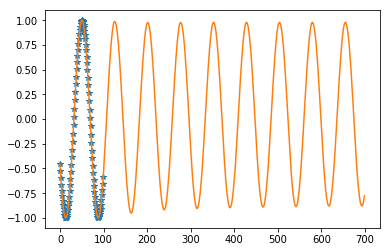

In [22]:
initial_dataset_1 = get_dataset(SEQ)
initial_iterator_1 = initial_dataset_1.make_one_shot_iterator()

generate_function(initial_iterator_1)

## 3

Different function

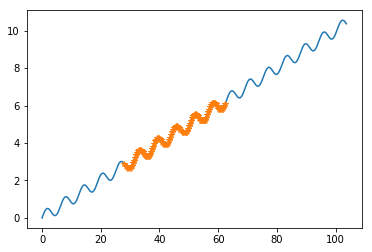

In [12]:
SEQ = 100
N = 33.
RESOLUTION = 300

def f(x):
    return (1/3.)*np.sin(x) + 0.1*x

FUNC = f

train_dataset_2 = get_dataset(SEQ)
train_dataset_2 = train_dataset_2.repeat(2)
train_iterator_2 = train_dataset_2.make_one_shot_iterator()

with tf.Session() as sess:
    hdl = sess.run(train_iterator_2.string_handle())
    x,y_ = sess.run([idx,y],{handle:hdl})
    
    x_full = np.linspace(0,N*np.pi,RESOLUTION)
    plt.plot(x_full,FUNC(x_full))
    plt.plot(x[0],y_[0,:,0],'*')

In [14]:
tf.set_random_seed(101)
np.random.seed(101)
train_rnn(train_iterator_2)

SEQ : 100
Batch:  0 26.458479
Batch:  500 2.0856404
Batch:  1000 0.12536661
Batch:  1500 0.093140714
Batch:  2000 0.06794276
Batch:  2500 0.04977532
Batch:  3000 0.03205678
Batch:  3500 0.017861696
Batch:  4000 0.0077463686
Elapsed time :  57.526965618133545  s


In [15]:
initial_dataset_2 = get_dataset(SEQ)
initial_iterator_2 = initial_dataset_2.make_one_shot_iterator()

INFO:tensorflow:Restoring parameters from models/RNN4/my_first_model.ckpt


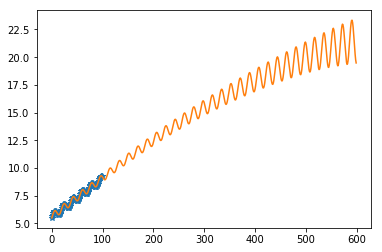

In [17]:
generate_function(initial_iterator_2,gen_len=500)

## 4)

GRU
 
Increased learning rate

In [6]:
HIDDEN = 100
# cells = [tf.keras.layers.GRUCell(HIDDEN,activation=tf.nn.relu),]
# rnn_layer = tf.keras.layers.RNN(cells,return_sequences=True)
rnn_layer = tf.keras.layers.CuDNNGRU(HIDDEN,return_sequences=True)
#rnn_layer = tf.keras.layers.CuDNNLSTM(HIDDEN,return_sequences=True)
#rnn_layer = tf.keras.layers.SimpleRNN(HIDDEN,return_sequences=True,activation=None)

def get_network(X,reuse=tf.AUTO_REUSE):
    with tf.variable_scope("RNN",reuse=reuse):
        H = tf.nn.relu(rnn_layer(X))
    with tf.variable_scope("Out",reuse=reuse):
        outputs = tf.layers.dense(H,1)
        
    return outputs

target = y[:,1:]
X = y[:,:-1]

outputs = get_network(X)
    
loss = tf.reduce_mean(tf.square(outputs-target))
train = tf.train.AdamOptimizer(0.001).minimize(loss)
saver = tf.train.Saver()

x_in = tf.placeholder(tf.float32,(None,None,1))
outputs_eval = get_network(x_in,reuse=True)

In [7]:
SEQ = 100
N = 33.
RESOLUTION = 300

def f(x):
    return (1/3.)*np.sin(x) + 0.1*x

FUNC = f

train_dataset_2 = get_dataset(SEQ)
train_dataset_2 = train_dataset_2.repeat(2)
train_iterator_2 = train_dataset_2.make_one_shot_iterator()

In [9]:
tf.set_random_seed(101)
np.random.seed(101)
train_rnn(train_iterator_2)

SEQ : 100
Batch:  0 25.969564
Batch:  500 2.0085359
Batch:  1000 0.05962534
Batch:  1500 0.02407925
Batch:  2000 0.0041223336
Batch:  2500 0.008701077
Batch:  3000 0.0046203784
Batch:  3500 0.0013071
Batch:  4000 0.0021728934
Elapsed time :  10.36012077331543  s


In [10]:
initial_dataset_2 = get_dataset(SEQ)
initial_iterator_2 = initial_dataset_2.make_one_shot_iterator()

INFO:tensorflow:Restoring parameters from models/RNN4/my_first_model.ckpt


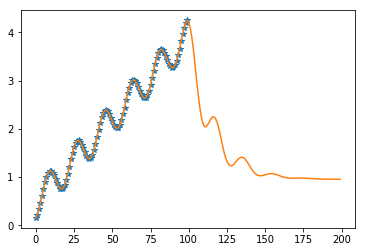

In [22]:
generate_function(initial_iterator_2,gen_len=100)

## 5)

In [8]:
HIDDEN = 100
#cells = [tf.keras.layers.GRUCell(HIDDEN,activation=tf.nn.relu),]
#rnn_layer = tf.keras.layers.RNN(cells,return_sequences=True)
rnn_layer = tf.keras.layers.CuDNNGRU(HIDDEN,return_sequences=True)

def get_network(X,reuse=tf.AUTO_REUSE):
    with tf.variable_scope("RNN",reuse=reuse):
        H = tf.nn.relu(rnn_layer(X))
    with tf.variable_scope("Out",reuse=reuse):
        outputs = tf.layers.dense(H,1)
        
    return outputs

target = y[:,1:]
X = y[:,:-1]

outputs = get_network(X)
    
loss = tf.reduce_mean(tf.square(outputs-target))
train = tf.train.AdamOptimizer(0.001).minimize(loss)
saver = tf.train.Saver()

x_in = tf.placeholder(tf.float32,(None,None,1))
outputs_eval = get_network(x_in,reuse=True)

In [62]:
# SEQ = 30
# N = 4.
# RESOLUTION = 300

SEQ = 100
N = 8.
RESOLUTION = 300

# SEQ = 100
# N = 33.
# RESOLUTION = 300

def f(x):
    return (1/100.)*np.sin(x) + 0.1*x
    #np.sin(x)

FUNC = f

def minmaxscale(y):
    min_y = tf.reduce_min(y)
    max_y = tf.reduce_max(y)
    return tf.div(y - min_y,max_y-min_y)
    

train_dataset_2 = get_dataset(SEQ)
#train_dataset_2 = train_dataset_2.map(lambda x,y: (x,minmaxscale(y)))
train_dataset_2 = train_dataset_2.repeat(2)
train_iterator_2 = train_dataset_2.make_one_shot_iterator()

In [63]:
tf.set_random_seed(101)
np.random.seed(101)
train_rnn(train_iterator_2)

SEQ : 100
Batch:  0 1.8352761
Batch:  500 0.03586686
Batch:  1000 0.0022882489
Batch:  1500 0.00056209916
Batch:  2000 0.0002616339
Batch:  2500 0.00023631778
Batch:  3000 5.185476e-05
Batch:  3500 5.0135168e-05
Batch:  4000 0.00013269192
Elapsed time :  10.57024097442627  s


In [66]:
initial_dataset_2 = get_dataset(SEQ)
#initial_dataset_2 = initial_dataset_2.map(lambda x,y: (x,minmaxscale(y)))
initial_iterator_2 = initial_dataset_2.make_one_shot_iterator()

INFO:tensorflow:Restoring parameters from models/RNN4/my_first_model.ckpt


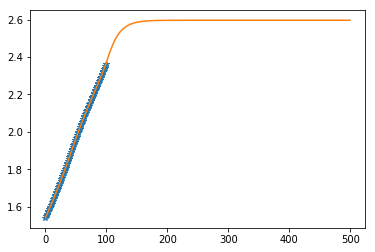

In [68]:
generate_function(initial_iterator_2,gen_len=400)

## 6)

In [7]:
HIDDEN = 300
rnn_layer = tf.keras.layers.CuDNNGRU(HIDDEN,return_sequences=True)

def get_network(X,reuse=tf.AUTO_REUSE):
    with tf.variable_scope("RNN",reuse=reuse):
        H = tf.nn.relu(rnn_layer(X))
    with tf.variable_scope("Out",reuse=reuse):
        outputs = tf.layers.dense(H,1)
        
    return outputs

target = y[:,1:]
X = y[:,:-1]

outputs = get_network(X)
    
loss = tf.reduce_mean(tf.square(outputs-target))
train = tf.train.AdamOptimizer(0.001).minimize(loss)
saver = tf.train.Saver()

x_in = tf.placeholder(tf.float32,(None,None,1))
outputs_eval = get_network(x_in,reuse=True)

In [8]:
SEQ = 600
N = 66.
RESOLUTION = 1000

b = np.random.uniform(-.05,.05,10)
def f(x):
    y = 0.5
    for i in range(1,10):
        omega = i*np.pi/20.
        y -= (0.318/i)*np.sin(omega*x) + b[i]*np.cos(omega*x)
        
    return y

FUNC = f

train_dataset_2 = get_dataset(SEQ)
train_dataset_2 = train_dataset_2.repeat(1)
train_iterator_2 = train_dataset_2.make_one_shot_iterator()

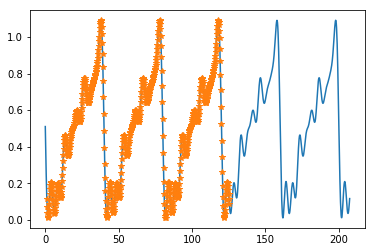

In [9]:
with tf.Session() as sess:
    hdl = sess.run(train_iterator_2.string_handle())
    x,y_ = sess.run([idx,y],{handle:hdl})
    
    x_full = np.linspace(0,N*np.pi,RESOLUTION)
    plt.plot(x_full,FUNC(x_full))
    plt.plot(x[0],y_[0,:,0],'*')

In [10]:
tf.set_random_seed(101)
np.random.seed(101)
train_rnn(train_iterator_2)

SEQ : 600
Batch:  0 0.2903715
Batch:  500 0.0019602573
Batch:  1000 0.00014695858
Batch:  1500 4.551423e-05
Batch:  2000 1.9967201e-05
Elapsed time :  51.53957152366638  s


In [16]:
SEQ=100
initial_dataset_2 = get_dataset(SEQ)
initial_iterator_2 = initial_dataset_2.make_one_shot_iterator()

INFO:tensorflow:Restoring parameters from models/RNN4/my_first_model.ckpt


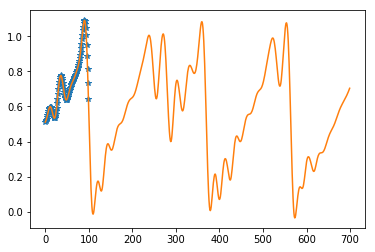

In [19]:
generate_function(initial_iterator_2,gen_len=600)

In [49]:
train_dataset_2 = get_dataset(SEQ)

In [51]:
def minmaxscale(y):
    min_y = tf.reduce_min(y)
    max_y = tf.reduce_max(y)
    return tf.div(y - min_y,max_y-min_y)
    
train_dataset_2 = train_dataset_2.map(lambda x,y: (x,minmaxscale(y)))

In [52]:
train_iterator_2 = train_dataset_2.make_one_shot_iterator()

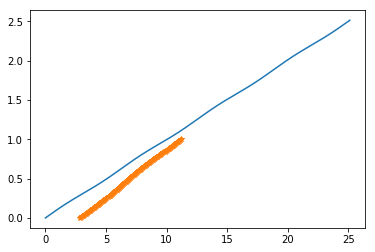

In [55]:
with tf.Session() as sess:
    hdl = sess.run(train_iterator_2.string_handle())
    x,y_ = sess.run([idx,y],{handle:hdl})
    
    x_full = np.linspace(0,N*np.pi,RESOLUTION)
    plt.plot(x_full,FUNC(x_full))
    plt.plot(x[0],y_[0,:,0],'*')